# Emotion Patterns in Music Playlists

Please refer to [https://github.com/sgiammy/emotion-patterns-in-music-playlists](https://github.com/sgiammy/emotion-patterns-in-music-playlists) for more details on the code which is used in this notebook.

In [1]:
import spacy
import os
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()

import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

lyrics_path = './ml_lyrics'

emotion_labels = ['happy', 'sad', 'relaxed', 'angry']

In [2]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

This notebook has the sole purpose of providing us an experimental environment in which we can quickly test our intuitions and ideas. Therefore, even though for the final algorithm we plan to use FastText, for this notebook we will use a pre-trainend language model available in spaCy containing 685k unique vectors trained on Common Crawl.

For more information about the language model we are using, please refer to [this](https://spacy.io/models/en) link.

In [3]:
# For this notebook we will use a simple spacy vocabulary
# because we just need to do some experiments
spacy_lang = 'en_core_web_lg'
nlp = spacy.load(spacy_lang)

In [4]:
# The language model we are using has some issues with stop words.
# Basically we need to grab stopwords from the 'en' language model
# and add them back to the model we are using.
# https://github.com/explosion/spaCy/issues/922
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)

12

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Emotion-Patterns-in-Music-Playlists" data-toc-modified-id="Emotion-Patterns-in-Music-Playlists-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Emotion Patterns in Music Playlists</a></span></li><li><span><a href="#The-Dataset:-MoodyLyrics" data-toc-modified-id="The-Dataset:-MoodyLyrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Dataset: MoodyLyrics</a></span></li><li><span><a href="#Lyrics-Preprocessing" data-toc-modified-id="Lyrics-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Lyrics Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Lyrics-Download" data-toc-modified-id="Lyrics-Download-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lyrics Download</a></span></li><li><span><a href="#Stopwords-deletion" data-toc-modified-id="Stopwords-deletion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Stopwords deletion</a></span></li><li><span><a href="#Preprocessing-Function" data-toc-modified-id="Preprocessing-Function-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Preprocessing Function</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Principal Component Analysis</a></span></li><li><span><a href="#Feature-Engineering-Function" data-toc-modified-id="Feature-Engineering-Function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Engineering Function</a></span></li></ul></li><li><span><a href="#Classifiers-on-Lyrics-Content" data-toc-modified-id="Classifiers-on-Lyrics-Content-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classifiers on Lyrics Content</a></span><ul class="toc-item"><li><span><a href="#Supervised-K-Means" data-toc-modified-id="Supervised-K-Means-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Supervised K-Means</a></span></li><li><span><a href="#k-Nearest-Neighbour" data-toc-modified-id="k-Nearest-Neighbour-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>k-Nearest Neighbour</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Gradient Boost</a></span></li><li><span><a href="#Artifical-Neural-Network" data-toc-modified-id="Artifical-Neural-Network-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Artifical Neural Network</a></span></li></ul></li><li><span><a href="#What-if-we-just-consider-the-song-title?" data-toc-modified-id="What-if-we-just-consider-the-song-title?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>What if we just consider the song title?</a></span><ul class="toc-item"><li><span><a href="#SVM-with-title-only" data-toc-modified-id="SVM-with-title-only-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>SVM with title only</a></span></li><li><span><a href="#Gradient-Boost-with-title-only" data-toc-modified-id="Gradient-Boost-with-title-only-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Gradient Boost with title only</a></span></li><li><span><a href="#Artificial-Neural-Network-with-title-only" data-toc-modified-id="Artificial-Neural-Network-with-title-only-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Artificial Neural Network with title only</a></span></li></ul></li><li><span><a href="#Song-Content-+-Song-Title" data-toc-modified-id="Song-Content-+-Song-Title-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Song Content + Song Title</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Artificial Neural Network</a></span></li></ul></li></ul></div>

# The Dataset: MoodyLyrics

In the followign section we will provide some interesting statistics on the dataset we will be using throughtout the notebook: MoodyLyrics.<br>
ModdyLyrics has the following header: <br>
*<Index, Artist, Song, Emotion>*
where:
<ul>
    <li>*Index*: monotonically increasing ID</li>
    <li>*Artist*: name of the artist</li>
    <li>*Song*: title of the song</li>
    <li>*Emotion*: one between ['happy', 'sad', 'relaxed', 'angry']</li>
</ul>

Firstly, let's see how many rows we have in our dataset.

In [42]:
moodyLyricsDF = pd.read_csv('./datasets/MoodyLyrics.csv')
print(moodyLyricsDF.shape)

(2595, 4)


So we have 2596 rows, but the first one of course is the header. <br>

In MoodyLyrics we have 4 different emotion labels for our songs: happy, sad, relaxed and angry. Let's see how those 4 classes are distributed.

In [6]:
moodyLyricsDF.describe()

,Index,Artist,Song,Emotion
count,2595,2595,2595,2595
unique,2595,1672,2229,4
top,ML737,The Beatles,Silent Night,happy
freq,1,52,24,819


We can notice something weird! Some songs, such as "Silent Night" appear more than once.<br>
Let's check if this is because there are duplicated rows or just because there are songs with the same title but different artist. 

In [9]:
#print(moodyLyricsDF.Song.value_counts()[:10])
duplicatedCheck = moodyLyricsDF.groupby(['Artist','Song']).size().reset_index(name='count')
print(duplicatedCheck.shape)
duplicatedRows = duplicatedCheck [(duplicatedCheck ['count']>1)]
print(duplicatedRows.shape)
moodyLyricsDF[(moodyLyricsDF['Artist']=='Akon')]

(2509, 3)
(82, 3)


,Index,Artist,Song,Emotion
653,ML654,Akon,Don't Matter,angry
961,ML962,Akon,Lonely,sad
2417,ML2418,Akon,Lonely,sad
2538,ML2539,Akon,Don't Matter,angry


There are 82 duplicated rows. <br>
We now group by 'Artist' and 'Song', and we label each song with the most frequent emotion.

In [20]:
moodyLyricsDF = moodyLyricsDF.groupby(['Artist','Song'],as_index=False)['Emotion'].agg(lambda x:x.value_counts().index[0])
print(moodyLyricsDF.shape)
moodyLyricsDF[(moodyLyricsDF['Artist']=="Akon")]

(2509, 3)


,Artist,Song,Emotion
34,Akon,Don't Matter,angry
35,Akon,Lonely,sad


happy      819
sad        604
relaxed    597
angry      575
Name: Emotion, dtype: int64


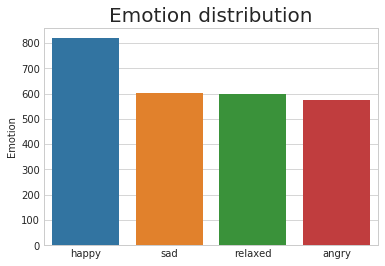

In [4]:
emotionDistribution = moodyLyricsDF.Emotion.value_counts()
print(emotionDistribution)
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution)
ax.set_title('Emotion distribution',fontsize=20)
ax.set_xticklabels(emotion_labels)
plt.show()

As we can see our lyrics are quite balanced among the 4 different classes. Only the happy class has some more lyrics with respect to the other threes. However we believe that it is not going to be a problem as the different between happy and other lyrics should not be too relevant.

Let's save the cleaned dataset into a csv file.

In [22]:
moodyLyricsDF.to_csv('./datasets/moodylyrics_cleaned.csv')

# Lyrics Preprocessing

Now we will move on analyzing several techniques for lyrics preprocessing, eventually evaluating their effects and their performances.

## Lyrics Download

First, let's download the lyrics from lyricwikia

In [12]:
import lyricwikia
import argparse
import sys
import os
import shutil

from utils.progress import progress

def download_lyrics(input,output,skipHeader=True):

    def songs_count(path):
        with open(path) as f:
            count = len(f.readlines()) - 1
            if skipHeader:
                count -= 1
            return count

    # Generator function which reads the lyrics from a csv file line by line
    def lyric_entries_generator(path):
        with open(path) as lp:
            l = lp.readline()
            if skipHeader:
                l = lp.readline()
            while l:
                yield l.rstrip().split(',')
                l = lp.readline()

    def create_output_dir(path):
        if os.path.exists(path) and os.path.isdir(path):
            shutil.rmtree(path)
        os.makedirs(path)


    LOG_FILE = '.'.join([input, 'log'])
    try:
        os.remove(os.path.join('.', LOG_FILE))
    except OSError:
      # Log file did not exists...not too bad
        pass

    def err(msg):
        with open(os.path.join('.', LOG_FILE), 'a') as log:
            log.write(msg)
            log.write('\n')

    def download_lyric(song):
        try:
            lyric = lyricwikia.get_lyrics(song[1], song[2])
            filename = '_'.join([song[3], song[1], song[2]])
            filename = filename.replace('/', '-') # The '/' should never appear
            with open(os.path.join(output, filename), 'w') as sfile:
                sfile.write(lyric)
                return True
        except lyricwikia.LyricsNotFound:
            err('Could not download {}'.format(song))
            return False


    # Get the number of songs we are going to download
    totalSongs = songs_count(input)

    # Create output directory
    create_output_dir(output)

    # Download songs
    count = 0 
    errCount = 0
    for lyric in lyric_entries_generator(input):
        progress(count, totalSongs, 'Errors encountered: {}'.format(errCount))
        if not download_lyric(lyric):
            errCount += 1
        count += 1

In [17]:
inputCsv = './datasets/moodylyrics_cleaned.csv'
outputDir = './ml_lyrics'
if os.path.exists(outputDir) and os.path.isdir(outputDir):
    pass
else:
    download_lyrics(inputCsv,outputDir)

Now let's see how many lyrics we have actually downloaded.

In [7]:
%%bash
ls -1 ml_lyrics/ | wc -l

2447


And let's analyse the emotion distribution considering only the song for which we have downloaded the lyrics.

In [11]:
count = dict(list(zip(emotion_labels, [0 for x in range(len(emotion_labels))])))

# Traverse the dataset directory
for root, dirs, files in os.walk(lyrics_path):
    for f in files:
        fields = f.split('_')
        if len(fields) > 0:
            count[fields[0]] += 1

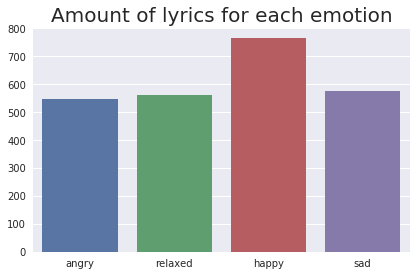

In [12]:
# Plot the obtained counts
# Plot
fig, ax = plt.subplots()
#fig.set_size_inches(10, 7)
ax = sns.barplot(x=list(count.keys()), y=list(count.values()), ax=ax)
ax.set_title('Amount of lyrics for each emotion',fontsize=20)
plt.tight_layout()
plt.show()

We can see that the emotion distribution looks alike the previous one.  

## Stopwords deletion

In one of our meetings for our project an interesting question was raised: does it really make sense to remove stopwords from lyrics? Would we have enough words after removing stopwords? Let's see what is the percentage change in the amount of words in our lyrics after removing stopwords. 

In [8]:
def remove_stopwords(doc):
    tks = list(filter(lambda tk: not tk.is_stop, doc))
    return spacy.tokens.Doc(nlp.vocab, words=[tk.text for tk in tks])

In [9]:
paths = load_dataset_from_path(lyrics_path)['Lyric_Path'].as_matrix()

# Build a dataframe with the following schema:
# <Song, word_count, words_after_stopwords_removal, percentage_change>
rows = list()

for path in paths:
    with open(path, 'r') as f:
        doc = nlp(f.read())
        n_words_before = len(doc)
        doc = remove_stopwords(doc)
        n_words_after = len(doc)
        perc = (n_words_before - n_words_after) / n_words_before * 100
        row = (path, n_words_before, n_words_after, perc)
        rows.append(row)

# Create a dataframe with the found information
df = pd.DataFrame(rows, columns=['Lyric', 'Word_Count', 
                  'Word_Count_After', 'Percentage_Change'])
print(df[:5])

                                               Lyric  Word_Count  \
0  /home/mario/dev/emotion-patterns-in-music-play...         161   
1  /home/mario/dev/emotion-patterns-in-music-play...        1151   
2  /home/mario/dev/emotion-patterns-in-music-play...         391   
3  /home/mario/dev/emotion-patterns-in-music-play...         297   
4  /home/mario/dev/emotion-patterns-in-music-play...         759   

   Word_Count_After  Percentage_Change  
0                85          47.204969  
1               562          51.172893  
2               245          37.340153  
3               186          37.373737  
4               417          45.059289  


In [9]:
# Print some statistics
percs = [ 25, 30, 40, 50, 60, 75 ]
print('Percentage of change in lyrics after removing stopwords:')
it = enumerate(percs)
plt_data = list()
for (i, perc) in it:
    if i == 0: 
        count = len(df[df['Percentage_Change'] < perc])
        #print(' - < {}:\t\t\t{}'.format(perc, count))
        plt_data.append(('< {}'.format(perc), count))
    elif i == len(percs) - 1:
        prev_p = percs[i-1]
        count = len(df[(df['Percentage_Change'] >= prev_p) & (df['Percentage_Change'] < perc)])
        #print(' - between {} and {}:\t{}'.format(prev_p, perc, count))
        plt_data.append(('>= {} and < {}'.format(prev_p, perc, count), count))
        
        count = len(df[df['Percentage_Change'] >= perc])
        #print(' - >= {}:\t\t\t{}'.format(perc, count))
        plt_data.append(('>= {}'.format(perc), count))
    else:
        prev_p = percs[i-1]
        count = len(df[(df['Percentage_Change'] >= prev_p) & (df['Percentage_Change'] < perc)])
        #print(' - between {} and {}:\t{}'.format(prev_p, perc, count))
        plt_data.append(('>= {} and < {}'.format(prev_p, perc, count), count))

pltDf = pd.DataFrame(plt_data)
print(pltDf)

Percentage of change in lyrics after removing stopwords:
                0     1
0            < 25   225
1  >= 25 and < 30    74
2  >= 30 and < 40   495
3  >= 40 and < 50  1009
4  >= 50 and < 60   585
5  >= 60 and < 75    59
6           >= 75     0


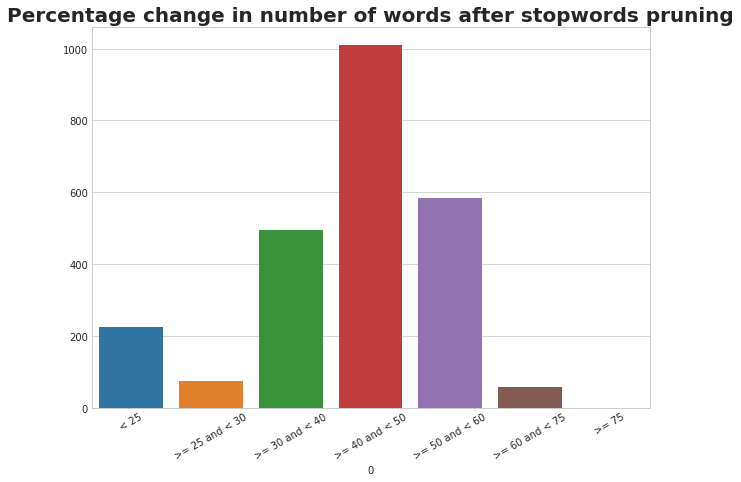

In [24]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.barplot(pltDf[0], pltDf[1], ax=ax)
plt.title('Percentage change in number of words after stopwords pruning', weight='bold', fontsize=20)
plt.xticks(rotation=30)
plt.ylabel('')
plt.show()

As we can see from the above plot, there is a minimum (but still relevant to our purpose) impact on lyrics, which still have a large number of words to be analyzed. Very few songs reduced their size of more then the 50% and for those songs we may probably have some issues. However this is a really small amount of lyrics that does not prevent us from saying that stopword deletion can be used as a good pre-processing technique for our model.

## Preprocessing Function
Now that we have defined which kind of preprocessing is good to apply to the text of our songs, let's define a function which will be used throughout the notebook to perform lyrics preprocessing.

In [10]:
def doc_preprocess(doc):
    d = remove_stopwords(doc)
    return d

# Feature Engineering
We will now move on trying to extract some interesting feature from our dataset. 

An important thing we need to state before starting analyzing this section, is that, by using spaCy's language model, each document has a word vector of length 300. SpaCy's language model has vectors of length 300 because it uses [GloVe](https://nlp.stanford.edu/projects/glove/) to train its models which is based on word2vec and assigns vectors of length 300 to each word.

## Principal Component Analysis
As we already said, the language model we are usin assigns word vectors of length 300 to documents and words. However this dimension may be too huge for our problem. In fact it is possible that, by performing some dimensionality reduction, we could still obtain good results from our model.

First of all we will perform PCA with 2 components, just because we want to visualize the effect of dimensionality reduction on our dataset.

In [12]:
# Read dataset into pandas dataframe
pca_dataset = load_dataset_from_path(lyrics_path)

# Turn emotion labels into numerical features
mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) # { 'happy' : 0, 'sad': 1, 'relaxed': 2, 'angry': 3 }
pca_dataset['Emotion'] = pca_dataset['Emotion'].map(mapping)

# Make the dataset to follow this scema:
# <Lyric_Path, Emotion, Vector, Vector_Norm>
rows = list()
pca_dataset['Vector'] = np.nan
for index, row in pca_dataset.iterrows():
    lyric = row['Lyric_Path']
    emotion = row['Emotion']
    with open(lyric, 'r') as lyric_file: 
        doc = nlp(lyric_file.read())
        doc = doc_preprocess(doc)
        # Consider only those vectors with the same length
        # This will be avoided when we will have proper PCA
        if len(doc.vector) == 300:
            rows.append((
                emotion, doc.vector
            ))
pca_dataset = pd.DataFrame(rows, columns=['Emotion', 'Vector'])

In [13]:
pca_X_vect = pca_dataset['Vector'].as_matrix()
pca_X_vect = np.array([np.array(x) for x in pca_X_vect])
pca_y = pca_dataset['Emotion'].as_matrix()

In [14]:
def pca(n_components):
    pca = PCA(n_components=n_components)
    pca.fit(pca_X_vect)
    return pca.transform(pca_X_vect)

In [15]:
components = pca(2)

In [16]:
# Put reduced components and labels together for plotting
comps = list(zip(components, pca_y))
pca_df = pd.DataFrame(comps, columns=['Vector', 'Emotion'])

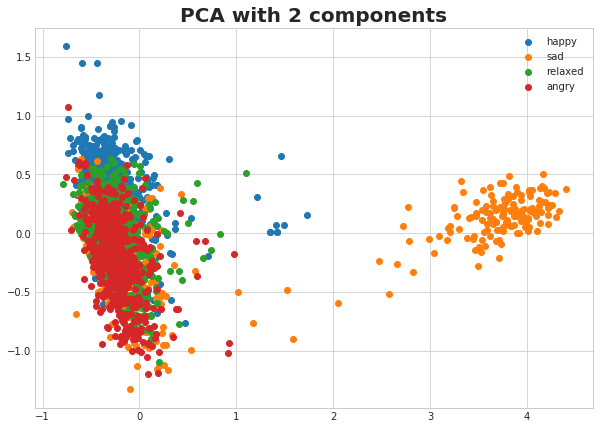

In [22]:
# Plot points for each class
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
for i in range(4):
    emo_df = pca_df[pca_df['Emotion'] == i]
    x = emo_df['Vector'].as_matrix()
    x = np.array([np.array(k) for k in x])
    plt.scatter(x[:,0], x[:,1])
plt.legend(emotion_labels)
plt.title('PCA with 2 components', weight='bold', fontsize=20)
plt.show()

Of course we were not expecting to obtain fantastic results. However we believed that doing a PCA with two components could have been great, especially because of the arousal-valence based songs classification model which was used in MoodyLyrics. 

We will abandon PCA for now.

## Feature Engineering Function
Now that we have defined which kind of feature engineering we want to, let's define a function which will be used throughout the notebook to perform the desired operations on the dataset.

In [11]:
# TODO: we still have to properly define which feature 
# engineering we want to perform
def feature_engineer(dataset):
    return dataset

# Classifiers on Lyrics Content
In the next sections we will provide the implementation of several classification algorithms we used. Those classifiers work on the 300-shaped vector assigned by our language model to the lyrics of each song.

First, let's prepare the data for those classifiers.

In [12]:
def load_dataset(lyrics_path):
    # Read dataset into pandas dataframe
    dataset = load_dataset_from_path(lyrics_path)

    # Turn emotion labels into numerical features
    mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) # { 'happy' : 0, 'sad': 1, 'relaxed': 2, 'angry': 3 }
    dataset['Emotion'] = dataset['Emotion'].map(mapping)

    # Make the dataset to follow this scema:
    # <Lyric_Path, Emotion, Vector, Vector_Norm>
    rows = list()
    dataset['Vector'] = np.nan
    dataset['Vector_Norm'] = np.nan
    for index, row in dataset.iterrows():
        lyric = row['Lyric_Path']
        emotion = row['Emotion']
        with open(lyric, 'r') as lyric_file: 
            doc = nlp(lyric_file.read())
            doc = doc_preprocess(doc) # Preprocessing step
            # Consider only those vectors with the same length
            # This will be avoided when we will have proper PCA
            if len(doc.vector) == 300:
                rows.append((
                    lyric,
                    emotion, doc.vector,
                    doc.vector_norm
                ))
    dataset = pd.DataFrame(rows, columns=['Lyric_Path', 'Emotion', 'Vector', 'Vector_Norm'])
    #dataset = feature_engineer(dataset) # Do feature engineering
    return dataset

In [71]:
dataset = load_dataset(lyrics_path)
# Show some dataset's values
dataset.head()

,Lyric_Path,Emotion,Vector,Vector_Norm
0,/home/mario/dev/emotion-patterns-in-music-play...,3,"[0.05747938, 0.18501352, -0.14104907, -0.04625...",2.859903
1,/home/mario/dev/emotion-patterns-in-music-play...,0,"[-0.013439501, 0.17781271, -0.1585186, -0.0208...",2.633056
2,/home/mario/dev/emotion-patterns-in-music-play...,0,"[-0.030751104, 0.31046307, -0.15142494, -0.013...",3.019833
3,/home/mario/dev/emotion-patterns-in-music-play...,1,"[0.062542394, 0.08743761, -0.08960157, -0.0961...",2.446515
4,/home/mario/dev/emotion-patterns-in-music-play...,3,"[-0.0777918, 0.1709495, -0.16516578, -0.032506...",2.737937


In [14]:
# Prepare array for sklearn classifiers
X_vect = dataset['Vector'].as_matrix().T
X_vect = np.array([np.array(x) for x in X_vect])
X_norm = dataset['Vector_Norm'].as_matrix()
y = dataset['Emotion'].as_matrix()

In [15]:
print(np.shape(X_vect))
print(np.shape(y))

(2447, 300)
(2447,)


Here we provide a function to perform some additional tests.

In [90]:
import lyricwikia

def extra_test(classifier):
    songs = [
        ('Bobby McFerrin', 'Don\'t Worry, Be Happy', 'happy'),
        ('Queen', 'Don\'t Stop me Now', 'happy'),
        ('Pharrell Williams', 'Happy', 'happy'),
        ('The Monkees', 'I\'m a believer', 'happy'),
        
        ('R.E.M.', 'Everybody Hurts', 'sad'),
        ('Adele', 'Someone Like You', 'sad'),
        ('Pink Floyd', 'Wish you were here', 'sad'),
        ('Johnny Cash', 'Hurt', 'sad'),
        ('Nirvana', 'Smells like teen spirit', 'sad'),
        
        ('Rage Against the Machine', 'Killing in the name', 'angry'),
        ('Kanye West', 'Stronger', 'angry'),
        ('Smash Mouth', 'All Star', 'angry'),
        ('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry'),
        
        ('Blur', 'Song 2', 'relaxed') # I'm not quite confident about this labeling
    ]

    count_correct = 0
    for s in songs:
        # Download the lyric
        lyric = lyricwikia.get_lyrics(s[0], s[1])
        # Convert lyric to spacy Doc and preproces it
        doc = nlp(lyric)
        doc = doc_preprocess(doc)
        # Classify
        vect = np.array([doc.vector])
        label = classifier.predict(vect)
        if emotion_labels[label[0]] == s[2]:
            count_correct += 1
        print(s, '->', emotion_labels[label[0]], '(was supposed to be {})'.format(s[2]))
    print('We got {} predictions our of {} songs'.format(count_correct, len(songs)))
    print('Accuracy: %0.2f' % (count_correct / len(songs)))

## Supervised K-Means
This is the first and the easieast classifier idea we came up. We used this idea just to verify what we could do and if we were on the right path. 

The name we gave to this classifier could sound ambiguous but we believe that, once its functioning is explained, the name will sound more decent.

The idea behind this classifier is quite simple. The first thing we do is to compute the centroids for each emotion class. Then, to classify a lyric, we simply compare its word vector norm to the 4 centroids. At the end we will assign our lyric with the label of the closest "cluster".

In [165]:
from classifier.LyricsSupervisedKMeans import LyricsSupervisedKMeans

clf = LyricsSupervisedKMeans()
clf.set_lang(nlp)

# Split dataset into training and test sets
trainDf, testDf = split_train_validation(dataset)

X_sup_kmeans_train = trainDf['Vector_Norm'].as_matrix().T
X_sup_kmeans_train = np.array([np.array(x) for x in X_sup_kmeans_train])

y_sup_kmeans_train = trainDf['Emotion'].as_matrix()

# Train our model
clf.train(X_sup_kmeans_train, y_sup_kmeans_train)

# Evaluate accuracy
acc = clf.score(testDf)
print('Accuracy: %0.2f' % (acc))

Accuracy: 0.31


For this model we did not even implement cross-validation. We just split the dataset into a training set (90%) and a test set (10%) and we evaluated the classification accuracy on that test set. We decided not to implement cross-validation for this classifier as we believe it is not worth to spend time on it.

We were expecting poor results from this classifier but at least it served to the purpose of giving us a hint of which direction to follow. 

## k-Nearest Neighbour
We will now build a k-NN model which is basically a generalization of what we called "Supervised K-Means". We will evaluate our model for several different k values. The parameters passed to our model are quite self-explicative.

In [162]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_vect, y, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.81 (+/- 0.04)
Accuracy for k=3: 0.81 (+/- 0.05)
Accuracy for k=5: 0.81 (+/- 0.05)
Accuracy for k=7: 0.81 (+/- 0.05)
Accuracy for k=9: 0.82 (+/- 0.05)
Accuracy for k=11: 0.81 (+/- 0.04)
Accuracy for k=13: 0.82 (+/- 0.04)
Accuracy for k=15: 0.81 (+/- 0.04)
Accuracy for k=17: 0.81 (+/- 0.06)
Accuracy for k=19: 0.81 (+/- 0.06)
Accuracy for k=21: 0.81 (+/- 0.06)


The k-NN algorithm produced unexpectedly good results. As we can see the algorithm never reaches an accuracy value higher than 82%. From our observations we can conclude that `k=9` could be an good parameter for that model.

An interesting thing we noticed while running our experiments is that, when we read our dataset without preprocessing our lyrics, the accuracy was around 10% lower.

Let's do some more tests and see if this classifier is really that good. We will now try to classify some very popular songs which were labelled according to our personal tastes and to [IBM Tone Analyzer](https://tone-analyzer-demo.ng.bluemix.net/?cm_mc_uid=56761301373215210511228&cm_mc_sid_50200000=91001461523311389617&cm_mc_sid_52640000=29317781523311389622) ones. Those songs we are trying to classify are not available in MoodyLyrics.

In [164]:
clf = KNeighborsClassifier(n_neighbors=9, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
clf.fit(X_vect, y)
extra_test(clf)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> happy (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> sad (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> angry (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> angry (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> sad (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> relaxed (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> angry (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> angry (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> angry (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> sad (was suppose

Those results are encouraging and make us believe that we can certainly do even better.

## SVM
We will now train a Support Vector Machine using the algorithm available in sklearn. For this first experiment we did not change the default parameters of the SVM algorithm provided in sklearn.

In [203]:
from sklearn.svm import SVC

# Build model
clf = SVC()
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.59 (+/- 0.08)


Now let's see if we can improve our model's accuracy just my properly tuning our parameters. We will perform a [Grid Search](http://scikit-learn.org/stable/modules/grid_search.html) to properly tune our model using a cross validation approach to evaluating accuracy. We will operate on both the kernel function and the penalty parameter C.

Beware that the below cell takes quite a long time to run as the `SVC` train function complexity is more than quadratic and, having to run it several times, is quite expensive.

In [205]:
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['linear'], 'C': [ 0.01, 0.05, 1, 10, 100 ]},
    { 'kernel': ['rbf', 'sigmoid'], 'C': [ 0.01, 0.05, 0.1, 0.3, 0.8, 1, 3, 10, 50, 100, 150, 200 ] }
]

# Perform grid search
svm_best, best_params = parameters_grid_search(SVC, params, X_vect, y, verbose=1)
print('Parameters:', best_params)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  5.6min finished


Parameters: {'C': 10, 'kernel': 'linear'}


In [206]:
scores = cross_val_score(svm_best, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.90 (+/- 0.04)


Honestly we were not expecting the SVM model to be so good. Let's see how our optimal SVM performs on the extra test set as we did earlier.

In [208]:
extra_test(svm_best)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> angry (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> angry (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> angry (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> angry (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> angry (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> sad (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> sad (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> sad (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> happy (was supposed to b

That's not properly what we would expect from a predictor having 91% accuracy. Probably (you don't say?) we are overfitting. In fact, we would get better results even by using a random classifier instead of our "optimal" SVM.

One interesting thing we can notice is that a "Don't Worry, Be Happy" is labelled as angry. However it is quite explicit from the title (and also from the lyrics) that the song is about happiness. This obeservation suggests us that we should probably be considering also the song's title when computing our word vectors.

Let's now move on to some ensemble methods which are supposed to be even better.

## Gradient Boost
Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function ([reference link](https://en.wikipedia.org/wiki/Gradient_boosting)).

Since we already obtained great results using our SVM model, we will omit any grid search for parameters tuning on this model. In fact, a grid search on a Gradient Boosting Classifier would be quite expensive and would slow down our experiments a lot. Instead, some manual tuning is done.

In [209]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.86 (+/- 0.05)


After several attempts we did never succeed in obtaining higher accuracy values w.r.t. our SVM model. Therefore, given the slow training time for the GradientBoostingClassifier algorithm, we will keep using the SVM model.

However, let's have a look on Gradient Boost performances on our "extra" test set.

In [210]:
clf.fit(X_vect, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [211]:
extra_test(clf)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> angry (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> angry (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> angry (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> sad (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> angry (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> angry (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> angry (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> angry (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> sad (was supposed 

Thst's definitivelly better but we still need to improve a lot.

## Artifical Neural Network
Additionally to what we have already done we will now try to tune, train and evaluate an artificial neural network model with two hidden layers.

In [16]:
#1 Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

In [17]:
# y_nn should be a vector (len(X_vect),4), with a 1 in the right class
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_nn = np_utils.to_categorical(encoded_Y)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
#2 Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
#1 Importing the Keras libraries and packages
import keras
# Sequential module is required to initialize our ANN
from keras.models import Sequential
# Dense module is required to create the layers
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=300):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))

    # Adding second hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.5))

    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [28]:
classifier = build_ann('adam')
classifier.fit(X_train, y_nn, batch_size = 64, epochs = 50)

#1 Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred1 = np.argmax(y_pred,axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)

Epoch 1/50
1962/1962 [==============================] - 0s 199us/step - loss: 1.3823 - acc: 0.3012
Epoch 2/50
1962/1962 [==============================] - 0s 49us/step - loss: 1.2945 - acc: 0.4154
Epoch 3/50
1962/1962 [==============================] - 0s 50us/step - loss: 1.1512 - acc: 0.5377
Epoch 4/50
1962/1962 [==============================] - 0s 56us/step - loss: 0.9740 - acc: 0.6055
Epoch 5/50
1962/1962 [==============================] - 0s 48us/step - loss: 0.8528 - acc: 0.6519
Epoch 6/50
1962/1962 [==============================] - 0s 50us/step - loss: 0.7660 - acc: 0.7130
Epoch 7/50
1962/1962 [==============================] - 0s 49us/step - loss: 0.6951 - acc: 0.7543
Epoch 8/50
1962/1962 [==============================] - 0s 44us/step - loss: 0.6213 - acc: 0.7803
Epoch 9/50
1962/1962 [==============================] - 0s 50us/step - loss: 0.5755 - acc: 0.8109
Epoch 10/50
1962/1962 [==============================] - 0s 48us/step - loss: 0.5100 - acc: 0.8318
Epoch 11/50
1962/1

In [31]:
cm = confusion_matrix(y_pred1, y_nn_pred.argmax(axis=1))

In [33]:
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_nn_pred)
print('Accuracy: %0.2f' % (accuracy*100))

Accuracy: 92.87


In [21]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [128],
              'epochs': [50],
              'optimizer': ['adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print('Accuracy: %0.2f' % (best_accuracy*100))

Epoch 1/50
1761/1761 [==============================] - 0s 192us/step - loss: 1.3769 - acc: 0.2959
Epoch 2/50
1761/1761 [==============================] - 0s 32us/step - loss: 1.3503 - acc: 0.3566
Epoch 3/50
1761/1761 [==============================] - 0s 32us/step - loss: 1.2955 - acc: 0.4299
Epoch 4/50
1761/1761 [==============================] - 0s 39us/step - loss: 1.2238 - acc: 0.5060
Epoch 5/50
1761/1761 [==============================] - 0s 43us/step - loss: 1.1140 - acc: 0.5508
Epoch 6/50
1761/1761 [==============================] - 0s 44us/step - loss: 1.0167 - acc: 0.5781
Epoch 7/50
1761/1761 [==============================] - 0s 38us/step - loss: 0.9273 - acc: 0.6036
Epoch 8/50
1761/1761 [==============================] - 0s 36us/step - loss: 0.8705 - acc: 0.6468
Epoch 9/50
1761/1761 [==============================] - 0s 43us/step - loss: 0.8191 - acc: 0.6587
Epoch 10/50
1761/1761 [==============================] - 0s 39us/step - loss: 0.7799 - acc: 0.6803
Epoch 11/50
1761/1

1761/1761 [==============================] - 0s 28us/step - loss: 0.5416 - acc: 0.8262
Epoch 17/50
1761/1761 [==============================] - 0s 30us/step - loss: 0.5104 - acc: 0.8313
Epoch 18/50
1761/1761 [==============================] - 0s 27us/step - loss: 0.4678 - acc: 0.8484
Epoch 19/50
1761/1761 [==============================] - 0s 29us/step - loss: 0.4533 - acc: 0.8518
Epoch 20/50
1761/1761 [==============================] - 0s 30us/step - loss: 0.4338 - acc: 0.8631
Epoch 21/50
1761/1761 [==============================] - 0s 28us/step - loss: 0.3943 - acc: 0.8734
Epoch 22/50
1761/1761 [==============================] - 0s 28us/step - loss: 0.3934 - acc: 0.8762
Epoch 23/50
1761/1761 [==============================] - 0s 27us/step - loss: 0.3678 - acc: 0.8921
Epoch 24/50
1761/1761 [==============================] - 0s 27us/step - loss: 0.3639 - acc: 0.8830
Epoch 25/50
1761/1761 [==============================] - 0s 28us/step - loss: 0.3248 - acc: 0.8927
Epoch 26/50
1761/1761 

Epoch 49/50
1761/1761 [==============================] - 0s 27us/step - loss: 0.1907 - acc: 0.9387
Epoch 50/50
1761/1761 [==============================] - 0s 30us/step - loss: 0.2033 - acc: 0.9381
Epoch 1/50
1761/1761 [==============================] - 0s 271us/step - loss: 1.3902 - acc: 0.2709
Epoch 2/50
1761/1761 [==============================] - 0s 28us/step - loss: 1.3551 - acc: 0.3458
Epoch 3/50
1761/1761 [==============================] - 0s 27us/step - loss: 1.3044 - acc: 0.4083
Epoch 4/50
1761/1761 [==============================] - 0s 29us/step - loss: 1.2424 - acc: 0.4804
Epoch 5/50
1761/1761 [==============================] - 0s 28us/step - loss: 1.1530 - acc: 0.5503
Epoch 6/50
1761/1761 [==============================] - 0s 28us/step - loss: 1.0328 - acc: 0.5934
Epoch 7/50
1761/1761 [==============================] - 0s 29us/step - loss: 0.9432 - acc: 0.6190
Epoch 8/50
1761/1761 [==============================] - 0s 29us/step - loss: 0.8662 - acc: 0.6400
Epoch 9/50
1761/1

1762/1762 [==============================] - 0s 29us/step - loss: 0.6170 - acc: 0.7633
Epoch 15/50
1762/1762 [==============================] - 0s 30us/step - loss: 0.5863 - acc: 0.7917
Epoch 16/50
1762/1762 [==============================] - 0s 29us/step - loss: 0.5446 - acc: 0.8161
Epoch 17/50
1762/1762 [==============================] - 0s 29us/step - loss: 0.5211 - acc: 0.8178
Epoch 18/50
1762/1762 [==============================] - 0s 28us/step - loss: 0.4798 - acc: 0.8462
Epoch 19/50
1762/1762 [==============================] - 0s 41us/step - loss: 0.4721 - acc: 0.8468
Epoch 20/50
1762/1762 [==============================] - 0s 39us/step - loss: 0.4481 - acc: 0.8536
Epoch 21/50
1762/1762 [==============================] - 0s 32us/step - loss: 0.4161 - acc: 0.8570
Epoch 22/50
1762/1762 [==============================] - 0s 31us/step - loss: 0.4058 - acc: 0.8700
Epoch 23/50
1762/1762 [==============================] - 0s 29us/step - loss: 0.3953 - acc: 0.8734
Epoch 24/50
1762/1762 

In [120]:
def extra_test_ann(classifier):
    songs = [
        ('Bobby McFerrin', 'Don\'t Worry, Be Happy', 'happy'),
        ('Queen', 'Don\'t Stop me Now', 'happy'),
        ('Pharrell Williams', 'Happy', 'happy'),
        ('The Monkees', 'I\'m a believer', 'happy'),
        
        ('R.E.M.', 'Everybody Hurts', 'sad'),
        ('Adele', 'Someone Like You', 'sad'),
        ('Pink Floyd', 'Wish you were here', 'sad'),
        ('Johnny Cash', 'Hurt', 'sad'),
        ('Nirvana', 'Smells like teen spirit', 'sad'),
        
        ('Rage Against the Machine', 'Killing in the name', 'angry'),
        ('Kanye West', 'Stronger', 'angry'),
        ('Smash Mouth', 'All Star', 'angry'),
        ('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry'),
        
        ('Blur', 'Song 2', 'relaxed') # I'm not quite confident about this labeling
    ]

    count_correct = 0
    for s in songs:
        # Download the lyric
        lyric = lyricwikia.get_lyrics(s[0], s[1])
        # Convert lyric to spacy Doc and preproces it
        doc = nlp(lyric)
        doc = doc_preprocess(doc)
        # Classify
        vect = np.array([doc.vector])
        label = classifier.predict(sc.transform(vect))
        lbl = np.argmax(label[0])
        if emotion_labels[lbl] == s[2]:
            count_correct += 1
        print(s, '->', emotion_labels[lbl], '(was supposed to be {})'.format(s[2]))
    print('We got {} predictions our of {} songs'.format(count_correct, len(songs)))
    print('Accuracy: %0.2f' % (count_correct / len(songs)))

In [51]:
extra_test_ann(best_classifier)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> happy (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> sad (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> angry (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> sad (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> relaxed (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> angry (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> sad (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> happy (was supposed to

# What if we just consider the song title? 
Now let's try to perform the classification just considering the song title. We'll try SVM, Gradient Boost and an ANN to compare the accuracy.

In [43]:
print(moodyLyricsDF[:4])

  Index      Artist                Song  Emotion
0   ML1       Usher  There Goes My Baby  relaxed
1   ML2    Da'Ville          On My Mind  relaxed
2   ML3     Rihanna       Rockstar 101   relaxed
3   ML4  J. Holiday                 Bed  relaxed


In [44]:
# First we map the emotion labels into number: Happy=0, Sad=1, Relaxed=2, Angry=3
mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) 
moodyLyricsDF['Emotion'] = moodyLyricsDF['Emotion'].map(mapping)
print(moodyLyricsDF[:4])

  Index      Artist                Song  Emotion
0   ML1       Usher  There Goes My Baby        2
1   ML2    Da'Ville          On My Mind        2
2   ML3     Rihanna       Rockstar 101         2
3   ML4  J. Holiday                 Bed        2


In [45]:
# Then we transform the Song title with spaCy
rows = list()
for index,row in moodyLyricsDF.iterrows():
    doc = nlp(row['Song'])
    rows.append((
                    row['Artist'],
                    row['Song'],
                    row['Emotion'], doc.vector,
                    doc.vector_norm
                ))

dataset = pd.DataFrame(rows, columns=['Artist', 'Song', 'Emotion','Vector', 'Vector_Norm'])

In [46]:
print(dataset[:2])

     Artist                Song  Emotion  \
0     Usher  There Goes My Baby        2   
1  Da'Ville          On My Mind        2   

                                              Vector  Vector_Norm  
0  [-0.0121174995, 0.27217752, -0.34575003, 0.096...     4.293632  
1  [0.048868, 0.19073336, -0.32884666, 0.10816, 0...     4.351134  


In [53]:
# Prepare array for sklearn classifiers
X_vect_name = dataset['Vector'].as_matrix().T
X_vect_name = np.array([np.array(x) for x in X_vect_name])
X_norm_name = dataset['Vector_Norm'].as_matrix()
y_name = dataset['Emotion'].as_matrix()

## SVM with title only

In [230]:
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['linear'], 'C': [ 0.01, 0.05, 1, 10, 100 ]},
    { 'kernel': ['rbf', 'sigmoid'], 'C': [ 0.01, 0.05, 0.1, 0.3, 0.8, 1, 3, 10, 50, 100, 150, 200 ] }
]

# Perform grid search
svm_best, best_params = parameters_grid_search(SVC, params, X_vect_name, y_name, verbose=1)
print('Parameters:', best_params)
scores = cross_val_score(svm_best, X_vect_name, y_name, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  9.0min finished


Parameters: {'C': 100, 'kernel': 'sigmoid'}
Accuracy: 0.67 (+/- 0.05)


In [231]:
extra_test(svm_best)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> sad (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> happy (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> sad (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> sad (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> angry (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> sad (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> relaxed (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> angry (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> sad (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> sad (was supposed to be 

## Gradient Boost with title only

In [235]:
# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=50)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect_name, y_name, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.65 (+/- 0.05)


In [236]:
clf.fit(X_vect_name, y_name)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [237]:
extra_test(clf)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> happy (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> relaxed (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> angry (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> angry (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> relaxed (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> angry (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> angry (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> happy (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> happy (was s

## Artificial Neural Network with title only

In [55]:
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_vect_name = sc.fit_transform(X_vect_name)

In [56]:
encoder = LabelEncoder()
encoder.fit(y_name)
encoded_Y = encoder.transform(y_name)
y_nn = np_utils.to_categorical(encoded_Y)

In [57]:
kclf = KerasClassifier(build_fn = build_ann, batch_size = 128, epochs = 50)
accuracies = cross_val_score(estimator = kclf, X = X_vect_name, y = y_nn, cv = 10, n_jobs = 1)

Epoch 1/50
2335/2335 [==============================] - 1s 310us/step - loss: 1.3845 - acc: 0.2882
Epoch 2/50
2335/2335 [==============================] - 0s 38us/step - loss: 1.3563 - acc: 0.3293
Epoch 3/50
2335/2335 [==============================] - 0s 42us/step - loss: 1.3291 - acc: 0.3683
Epoch 4/50
2335/2335 [==============================] - 0s 44us/step - loss: 1.2791 - acc: 0.4287
Epoch 5/50
2335/2335 [==============================] - 0s 45us/step - loss: 1.2263 - acc: 0.4677
Epoch 6/50
2335/2335 [==============================] - 0s 56us/step - loss: 1.1639 - acc: 0.5191
Epoch 7/50
2335/2335 [==============================] - 0s 48us/step - loss: 1.1133 - acc: 0.5388
Epoch 8/50
2335/2335 [==============================] - 0s 41us/step - loss: 1.0706 - acc: 0.5503
Epoch 9/50
2335/2335 [==============================] - 0s 47us/step - loss: 1.0377 - acc: 0.5820
Epoch 10/50
2335/2335 [==============================] - 0s 35us/step - loss: 0.9945 - acc: 0.6283
Epoch 11/50
2335/2

2335/2335 [==============================] - 0s 33us/step - loss: 0.9404 - acc: 0.6450
Epoch 15/50
2335/2335 [==============================] - 0s 34us/step - loss: 0.9199 - acc: 0.6574
Epoch 16/50
2335/2335 [==============================] - 0s 32us/step - loss: 0.9001 - acc: 0.6595
Epoch 17/50
2335/2335 [==============================] - 0s 30us/step - loss: 0.8679 - acc: 0.6775
Epoch 18/50
2335/2335 [==============================] - 0s 31us/step - loss: 0.8695 - acc: 0.6779
Epoch 19/50
2335/2335 [==============================] - 0s 31us/step - loss: 0.8581 - acc: 0.6818
Epoch 20/50
2335/2335 [==============================] - 0s 32us/step - loss: 0.8329 - acc: 0.6994
Epoch 21/50
2335/2335 [==============================] - 0s 30us/step - loss: 0.8283 - acc: 0.6899
Epoch 22/50
2335/2335 [==============================] - 0s 29us/step - loss: 0.8088 - acc: 0.7045
Epoch 23/50
2335/2335 [==============================] - 0s 35us/step - loss: 0.7955 - acc: 0.7135
Epoch 24/50
2335/2335 

2336/2336 [==============================] - 0s 30us/step - loss: 0.7754 - acc: 0.7183
Epoch 28/50
2336/2336 [==============================] - 0s 32us/step - loss: 0.7601 - acc: 0.7290
Epoch 29/50
2336/2336 [==============================] - 0s 48us/step - loss: 0.7431 - acc: 0.7367
Epoch 30/50
2336/2336 [==============================] - 0s 36us/step - loss: 0.7700 - acc: 0.7252
Epoch 31/50
2336/2336 [==============================] - 0s 50us/step - loss: 0.7378 - acc: 0.7329
Epoch 32/50
2336/2336 [==============================] - 0s 33us/step - loss: 0.7487 - acc: 0.7290
Epoch 33/50
2336/2336 [==============================] - 0s 40us/step - loss: 0.7232 - acc: 0.7440
Epoch 34/50
2336/2336 [==============================] - 0s 48us/step - loss: 0.7277 - acc: 0.7389
Epoch 35/50
2336/2336 [==============================] - 0s 36us/step - loss: 0.7202 - acc: 0.7466
Epoch 36/50
2336/2336 [==============================] - 0s 47us/step - loss: 0.7151 - acc: 0.7440
Epoch 37/50
2336/2336 

2336/2336 [==============================] - 0s 34us/step - loss: 0.6873 - acc: 0.7517
Epoch 41/50
2336/2336 [==============================] - 0s 34us/step - loss: 0.6921 - acc: 0.7517
Epoch 42/50
2336/2336 [==============================] - 0s 38us/step - loss: 0.6922 - acc: 0.7521
Epoch 43/50
2336/2336 [==============================] - 0s 32us/step - loss: 0.6924 - acc: 0.7551
Epoch 44/50
2336/2336 [==============================] - 0s 32us/step - loss: 0.6795 - acc: 0.7491
Epoch 45/50
2336/2336 [==============================] - 0s 33us/step - loss: 0.6945 - acc: 0.7539
Epoch 46/50
2336/2336 [==============================] - 0s 34us/step - loss: 0.6685 - acc: 0.7607
Epoch 47/50
2336/2336 [==============================] - 0s 32us/step - loss: 0.6633 - acc: 0.7748
Epoch 48/50
2336/2336 [==============================] - 0s 35us/step - loss: 0.6748 - acc: 0.7616
Epoch 49/50
2336/2336 [==============================] - 0s 31us/step - loss: 0.6855 - acc: 0.7581
Epoch 50/50
259/259 [=

In [58]:
print('Mean Accuracy:', accuracies.mean())
print('Standard Deviation:', accuracies.std())

Mean Accuracy: 0.7009400059975395
Standard Deviation: 0.02572823337502852


In [42]:
X_vect_name = dataset['Vector'].as_matrix().T
X_vect_name = np.array([np.array(x) for x in X_vect])

In [43]:
ann = build_ann()
ann.fit(X_vect_name, y_nn, batch_size = 128, epochs = 50)

Epoch 1/50
2453/2453 [==============================] - 2s 759us/step - loss: 1.3868 - acc: 0.2951
Epoch 2/50
2453/2453 [==============================] - 0s 38us/step - loss: 1.3854 - acc: 0.3004
Epoch 3/50
2453/2453 [==============================] - 0s 40us/step - loss: 1.3816 - acc: 0.3033
Epoch 4/50
2453/2453 [==============================] - 0s 41us/step - loss: 1.3721 - acc: 0.3229
Epoch 5/50
2453/2453 [==============================] - 0s 40us/step - loss: 1.3556 - acc: 0.3424
Epoch 6/50
2453/2453 [==============================] - 0s 39us/step - loss: 1.3475 - acc: 0.3624
Epoch 7/50
2453/2453 [==============================] - 0s 40us/step - loss: 1.3283 - acc: 0.3702
Epoch 8/50
2453/2453 [==============================] - 0s 41us/step - loss: 1.2993 - acc: 0.3946
Epoch 9/50
2453/2453 [==============================] - 0s 40us/step - loss: 1.2595 - acc: 0.4350
Epoch 10/50
2453/2453 [==============================] - 0s 40us/step - loss: 1.1994 - acc: 0.4721
Epoch 11/50
2453/2

In [57]:
extra_test_ann(ann)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> happy (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> happy (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> sad (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> sad (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> sad (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> sad (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> sad (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> sad (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> sad (was supposed to be angry)

# Song Content + Song Title
Here we propose an approach which is a sort of combination of the previous two.

We already understood that the best classifiers for our purpose are the SVM and the ANN so we will just use them.

First of all we will do our feature engineering, and then we will proceed to the classification.

In [74]:
# Prepare array for sklearn classifiers
X_vect = dataset['Vector'].as_matrix()
X_vect = np.array([np.array(x) for x in X_vect])

#X_vect_title
#pca = PCA(n_components=4)
#pca.fit(X_vect_pca)
#X_vect_comb = pca.transform(X_vect_pca)

X_vect_nl = list()

for (i, (index,row)) in enumerate(dataset.iterrows()):
    song_title = row['Lyric_Path'].split('_')[-1]#row['Song']
    title_doc = nlp(song_title)
    title_comp = title_doc.vector_norm
    X_vect_nl.append(np.concatenate((X_vect[i], [title_comp])))
    
X_vect_nl = np.array(X_vect_nl)

## SVM
We will repeat the same operations with did eariler. If you want more detailed explainations, please refer to the "Classifiers on Lyrics Content" section.

In [76]:
from sklearn.svm import SVC

# Build model
clf = SVC()
# Evaluate accuracy
scores = cross_val_score(clf, X_vect_nl, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.57 (+/- 0.04)


In [88]:
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['linear'], 'C': [ 0.01, 0.05, 1, 10, 100 ]},
    { 'kernel': ['rbf', 'sigmoid'], 'C': [ 0.01, 0.05, 0.1, 0.3, 0.8, 1, 3, 10, 50, 100, 150, 200 ] }
]

# Perform grid search
svm_best, best_params = parameters_grid_search(SVC, params, X_vect_nl, y, verbose=1)
print('Parameters:', best_params)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished


Parameters: {'kernel': 'linear', 'C': 10}


In [90]:
scores = cross_val_score(svm_best, X_vect_nl, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.91 (+/- 0.04)


In [91]:
extra_test(svm_best)

('Bobby McFerrin', "Don't Worry, Be Happy", 'happy') -> angry (was supposed to be happy)
('Queen', "Don't Stop me Now", 'happy') -> sad (was supposed to be happy)
('Pharrell Williams', 'Happy', 'happy') -> happy (was supposed to be happy)
('The Monkees', "I'm a believer", 'happy') -> angry (was supposed to be happy)
('R.E.M.', 'Everybody Hurts', 'sad') -> angry (was supposed to be sad)
('Adele', 'Someone Like You', 'sad') -> angry (was supposed to be sad)
('Pink Floyd', 'Wish you were here', 'sad') -> sad (was supposed to be sad)
('Johnny Cash', 'Hurt', 'sad') -> angry (was supposed to be sad)
('Nirvana', 'Smells like teen spirit', 'sad') -> sad (was supposed to be sad)
('Rage Against the Machine', 'Killing in the name', 'angry') -> sad (was supposed to be angry)
('Kanye West', 'Stronger', 'angry') -> sad (was supposed to be angry)
('Smash Mouth', 'All Star', 'angry') -> sad (was supposed to be angry)
('Bloodhound Gang', 'The Ballad of Chasey Lain', 'angry') -> happy (was supposed to b

## Artificial Neural Network
Again, if you want more detailed information on what we will be doing in this section, please refer to what we wrote above.

In [79]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_vect_nl_ann = sc.fit_transform(X_vect_nl)

In [80]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
y_nn = np_utils.to_categorical(encoded_Y)

In [83]:
def build_ann(optimizer='adam', input_size=301):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 50, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))

    # Adding hidden layers
    classifier.add(Dense(units = 35, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.5))

    classifier.add(Dense(units = 15, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(units = 10, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.5))
    
    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [85]:
from keras.wrappers.scikit_learn import KerasClassifier

kclf = KerasClassifier(build_fn = build_ann, batch_size = 256, epochs = 100)
accuracies = cross_val_score(estimator = kclf, X = X_vect_nl_ann, y = y_nn, cv = 10, n_jobs = 1)

Epoch 1/100
2202/2202 [==============================] - 1s 603us/step - loss: 1.3887 - acc: 0.2448
Epoch 2/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.3831 - acc: 0.2893
Epoch 3/100
2202/2202 [==============================] - 0s 24us/step - loss: 1.3831 - acc: 0.2888
Epoch 4/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.3786 - acc: 0.2965
Epoch 5/100
2202/2202 [==============================] - 0s 27us/step - loss: 1.3798 - acc: 0.3111
Epoch 6/100
2202/2202 [==============================] - 0s 24us/step - loss: 1.3792 - acc: 0.3070
Epoch 7/100
2202/2202 [==============================] - 0s 22us/step - loss: 1.3772 - acc: 0.3074
Epoch 8/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.3771 - acc: 0.3120
Epoch 9/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.3756 - acc: 0.3161
Epoch 10/100
2202/2202 [==============================] - 0s 26us/step - loss: 1.3779 - acc: 0.3134
Epoch 11

2202/2202 [==============================] - 0s 18us/step - loss: 1.0685 - acc: 0.5123
Epoch 84/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0569 - acc: 0.5182
Epoch 85/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0684 - acc: 0.5218
Epoch 86/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0596 - acc: 0.5154
Epoch 87/100
2202/2202 [==============================] - 0s 20us/step - loss: 1.0622 - acc: 0.5218
Epoch 88/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0613 - acc: 0.5204
Epoch 89/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0524 - acc: 0.5250
Epoch 90/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.0448 - acc: 0.5268
Epoch 91/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.0554 - acc: 0.5250
Epoch 92/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.0421 - acc: 0.5272
Epoch 93/100


2202/2202 [==============================] - 0s 19us/step - loss: 1.3752 - acc: 0.3120
Epoch 46/100
2202/2202 [==============================] - 0s 20us/step - loss: 1.3747 - acc: 0.3120
Epoch 47/100
2202/2202 [==============================] - 0s 18us/step - loss: 1.3741 - acc: 0.3120
Epoch 48/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3739 - acc: 0.3120
Epoch 49/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3741 - acc: 0.3120
Epoch 50/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3729 - acc: 0.3120
Epoch 51/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3693 - acc: 0.3120
Epoch 52/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3678 - acc: 0.3120
Epoch 53/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3636 - acc: 0.3120
Epoch 54/100
2202/2202 [==============================] - 0s 19us/step - loss: 1.3585 - acc: 0.3120
Epoch 55/100


2202/2202 [==============================] - 0s 29us/step - loss: 1.3800 - acc: 0.3084
Epoch 8/100
2202/2202 [==============================] - 0s 27us/step - loss: 1.3788 - acc: 0.3093
Epoch 9/100
2202/2202 [==============================] - 0s 28us/step - loss: 1.3796 - acc: 0.3093
Epoch 10/100
2202/2202 [==============================] - 0s 27us/step - loss: 1.3806 - acc: 0.3084
Epoch 11/100
2202/2202 [==============================] - 0s 33us/step - loss: 1.3771 - acc: 0.3079
Epoch 12/100
2202/2202 [==============================] - 0s 26us/step - loss: 1.3790 - acc: 0.3088
Epoch 13/100
2202/2202 [==============================] - 0s 28us/step - loss: 1.3818 - acc: 0.3097
Epoch 14/100
2202/2202 [==============================] - 0s 31us/step - loss: 1.3780 - acc: 0.3088
Epoch 15/100
2202/2202 [==============================] - 0s 31us/step - loss: 1.3787 - acc: 0.3088
Epoch 16/100
2202/2202 [==============================] - 0s 31us/step - loss: 1.3783 - acc: 0.3093
Epoch 17/100
22

2202/2202 [==============================] - 0s 23us/step - loss: 1.1177 - acc: 0.4814
Epoch 90/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.1062 - acc: 0.4950
Epoch 91/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.1119 - acc: 0.4823
Epoch 92/100
2202/2202 [==============================] - 0s 24us/step - loss: 1.1056 - acc: 0.4946
Epoch 93/100
2202/2202 [==============================] - 0s 25us/step - loss: 1.0829 - acc: 0.4959
Epoch 94/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.0838 - acc: 0.4923
Epoch 95/100
2202/2202 [==============================] - 0s 24us/step - loss: 1.0748 - acc: 0.5077
Epoch 96/100
2202/2202 [==============================] - 0s 26us/step - loss: 1.0762 - acc: 0.5077
Epoch 97/100
2202/2202 [==============================] - 0s 26us/step - loss: 1.0576 - acc: 0.5082
Epoch 98/100
2202/2202 [==============================] - 0s 24us/step - loss: 1.0593 - acc: 0.5000
Epoch 99/100


2202/2202 [==============================] - 0s 21us/step - loss: 1.3766 - acc: 0.3084
Epoch 52/100
2202/2202 [==============================] - 0s 22us/step - loss: 1.3781 - acc: 0.3084
Epoch 53/100
2202/2202 [==============================] - 0s 21us/step - loss: 1.3772 - acc: 0.3084
Epoch 54/100
2202/2202 [==============================] - 0s 21us/step - loss: 1.3771 - acc: 0.3084
Epoch 55/100
2202/2202 [==============================] - 0s 23us/step - loss: 1.3771 - acc: 0.3084
Epoch 56/100
2202/2202 [==============================] - 0s 20us/step - loss: 1.3766 - acc: 0.3084
Epoch 57/100
2202/2202 [==============================] - 0s 20us/step - loss: 1.3754 - acc: 0.3084
Epoch 58/100
2202/2202 [==============================] - 0s 21us/step - loss: 1.3736 - acc: 0.3084
Epoch 59/100
2202/2202 [==============================] - 0s 21us/step - loss: 1.3698 - acc: 0.3084
Epoch 60/100
2202/2202 [==============================] - 0s 21us/step - loss: 1.3665 - acc: 0.3084
Epoch 61/100


2203/2203 [==============================] - 0s 22us/step - loss: 1.3769 - acc: 0.3177
Epoch 14/100
2203/2203 [==============================] - 0s 23us/step - loss: 1.3747 - acc: 0.3177
Epoch 15/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.3756 - acc: 0.3177
Epoch 16/100
2203/2203 [==============================] - 0s 23us/step - loss: 1.3748 - acc: 0.3177
Epoch 17/100
2203/2203 [==============================] - 0s 24us/step - loss: 1.3745 - acc: 0.3177
Epoch 18/100
2203/2203 [==============================] - 0s 25us/step - loss: 1.3736 - acc: 0.3177
Epoch 19/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.3764 - acc: 0.3177
Epoch 20/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.3755 - acc: 0.3177
Epoch 21/100
2203/2203 [==============================] - 0s 23us/step - loss: 1.3758 - acc: 0.3177
Epoch 22/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.3730 - acc: 0.3177
Epoch 23/100


2203/2203 [==============================] - 0s 22us/step - loss: 1.0270 - acc: 0.5388
Epoch 96/100
2203/2203 [==============================] - 0s 23us/step - loss: 1.0223 - acc: 0.5329
Epoch 97/100
2203/2203 [==============================] - 0s 21us/step - loss: 1.0137 - acc: 0.5456
Epoch 98/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.0152 - acc: 0.5347
Epoch 99/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.0171 - acc: 0.5447
Epoch 100/100
244/244 [==============================] - 1s 2ms/step
Epoch 1/100
2203/2203 [==============================] - 2s 795us/step - loss: 1.3852 - acc: 0.2633
Epoch 2/100
2203/2203 [==============================] - 0s 27us/step - loss: 1.3822 - acc: 0.2969
Epoch 3/100
2203/2203 [==============================] - 0s 22us/step - loss: 1.3809 - acc: 0.2932
Epoch 4/100
2203/2203 [==============================] - 0s 24us/step - loss: 1.3786 - acc: 0.3100
Epoch 5/100
2203/2203 [========================

In [86]:
print('Mean Accuracy:', accuracies.mean())
print('Standard Deviation:', accuracies.std())

Mean Accuracy: 0.5414653718471527
Standard Deviation: 0.03926198650268906


We have very bad performances also on the training set. There is no reason in attempting any further tests.